## Purpose: Determine aH and C based on the correct yield width functions

In the Edelweiss paper, aH and C are fit based on the Edelweiss resolution functions, which are incorrect.

This notebook determines aH based on a fit to the (correct) electron-recoil yield width, and then C and m based on a fit to the (correct) nuclear-yield width.  The nuclear-yield width is expressed with the aH determined in the electron-recoil yeild width.

The fit to the electron-recoil yield band uses the (correct) functional form `sigmomEdw` defined in `python/prob_dist.py` and aH is the sole parameter.  The fit to the nuclear-recoil yield band also uses the functional form `sigmomEdw` but fixes aH and introduces additional "width" with a constant and linear term:

$$\sigma_{NR}(E_{R}) = \sqrt{sigmomEdw(E_R)^2 + (C+m E_R)^2}$$

The quantity aH_FWHM is determined to be 0.03808166 +/- 0.001738 (4.56%). <br>
The quantity C is determined to be 0.03132232 +/- 0.003987 (12.73%). <br>
The quantity m is determined to be 0.00013000 +/- 8.24e-05 (63.38%).

Note that the correct function expresses aH as the aH_FWHM reported in the paper.  Currently, Amy's resolution functions - the incorrect Edelweiss functions - is expressed as aH_sigma.

In [39]:
import numpy as np
import pandas as pd
from joblib import Memory
import matplotlib.pyplot as plt
%matplotlib inline 

from scipy import optimize
import lmfit as lmf

import sys
sys.path.append('../python/')
from EdwRes import *
from prob_dist import *

### Pull in data from GGA3

This data is pulled from Figs ?? in the Edelweiss paper, from the svg image.

In [24]:
# import data from Edelweiss
res_data = pd.read_csv("data/edelweiss_NRwidth_GGA3_data.txt", skiprows=1, \
                       names=['E_recoil', 'sig_NR', 'E_recoil_err', 'sig_NR_err'], \
                       delim_whitespace=True)

resER_data = pd.read_csv("data/edelweiss_ERwidth_GGA3_data.txt", skiprows=1, \
                         names=['E_recoil', 'sig_ER', 'sig_ER_err'], \
                         delim_whitespace=True)

resER_data = resER_data.sort_values(by='E_recoil')

print (res_data.head(5))
E_recoil = res_data["E_recoil"]
sig_NR = res_data["sig_NR"]
sig_NR_err = res_data['sig_NR_err']

   E_recoil    sig_NR  E_recoil_err  sig_NR_err
0   16.1946  0.062345      0.946176    0.001157
1   16.4428  0.062345      0.945278    0.001157
2   44.2627  0.046528      0.992477    0.001543
3   24.5012  0.059397      0.992477    0.001185
4   97.7172  0.044847      1.033260    0.002783


In [40]:
# GGA3 parameters from Edelweiss tables
ion_center_0keV = 1.3
ion_guard_0keV = 1.5
heat_0keV = 0.4
ion_122keV = 3.1 
heat_122keV = 2.7
aH = 0.0157
pars = {
    'V' : 4.0,
    'eps_eV' : 3.0
    }

#sigmomEdw(x,band='ER',label='GGA3',F=0.000001,V=4.0,aH=aH,alpha=(1/1000.0))
def vsigmomEdw(Erecoil_keV, aH):
    return [sigmomEdw(x,band='ER',label='GGA3',F=0.000001,V=4.0,aH=aH,alpha=(1/1000.0)) for x in Erecoil_keV]

# it makes sense to memoize this function
cachedir = 'cache_dir'
memory = Memory(cachedir, verbose=0)

@memory.cache
def vsigmomEdw_NR(Erecoil_keV, aH):
    return [sigmomEdw(x,band='NR',label='GGA3',F=0.000001,V=4.0,aH=aH,alpha=(1/18.0)) for x in Erecoil_keV]

In [41]:
# lmfit needs a residuals function
# par_dict is a dictionary of the form
# {'V': 4.0, 'eps_eV': 3.0}
def residualNR(params, x, data, eps_data):
    aH = params['aH']
    C = params['C']
    m = params['m']

    sig0 = vsigmomEdw_NR(x, aH)
    sigC = C + np.multiply(x, m)
    model = np.sqrt(np.power(sig0,2)+np.power(sigC,2))

    return (data-model) / eps_data

def residualER(params, x, data, eps_data):
    aH = params['aH']
    
    #sigmomEdw(Er,band='ER',label='GGA3',F=0.000001,V=4.0,aH=0.035,alpha=(1/100))
    model = vsigmomEdw(x,aH)
    
    return (data-model) / eps_data

## Fit the electron-recoil yield width

This determines aH.

In [31]:
# Edelweiss fits aH first
paramsER = lmf.Parameters()
paramsER.add('aH', value=0.03808)
mask = [True, True, False, False, True, True, True, True, True]
    
# this code takes a long time to run, yields
# aH: 0.03808166 +/- 0.001738 (4.56%) (init= 0.01638)
# aH_sig is  0.016171087077483885 (this is for Amy's functions)
if False:
    lmfoutER = lmf.minimize(residualER, paramsER, \
                            args=(resER_data["E_recoil"][mask], resER_data["sig_ER"][mask], resER_data["sig_ER_err"][mask]))

    print('lmfit result--ER')
    print(lmf.report_fit(lmfoutER.params))
    # note that FWHM_to_SIG is from EdwRes library
    print('aH_sig is ', lmfoutER.params['aH']*FWHM_to_SIG)

In [32]:
if False:
    model_sig_ER = vsigmomEdw(resER_data["E_recoil"], paramsER['aH'])
else:
    model_sig_ER = [0.08355766981930605, 0.05950708438272898, 0.05172799515753696, 0.048276675932479834, 0.04652330116644231, 0.0454684492869768, 0.04484786654840544, 0.04440177110338151, 0.04407595910213763]

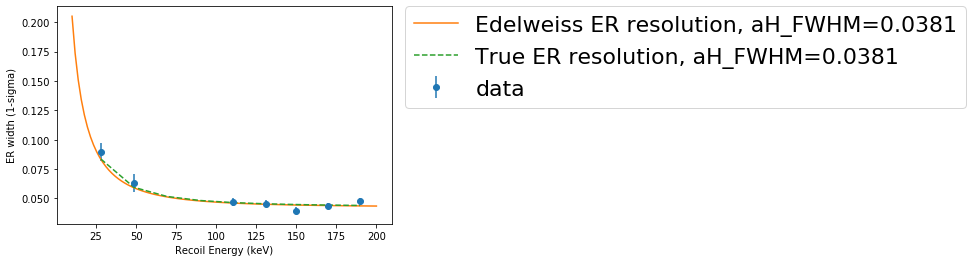

In [33]:
#sig_er_func = get_sig_gamma_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, pars, aH=lmfoutER.params['aH'])
sig_er_func = get_sig_gamma_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, pars, aH=paramsER['aH']*FWHM_to_SIG)
E_recoil_arr = np.linspace(10, 200, 100)

plt.errorbar(resER_data["E_recoil"][mask], resER_data["sig_ER"][mask],yerr=resER_data['sig_ER_err'][mask],fmt='o', label="data")
plt.plot(E_recoil_arr, sig_er_func(E_recoil_arr), label="Edelweiss ER resolution, aH_FWHM=0.0381")
plt.plot(resER_data["E_recoil"], model_sig_ER, '--', label="True ER resolution, aH_FWHM=0.0381")

plt.ylabel('ER width (1-sigma)')
plt.xlabel('Recoil Energy (keV)')
ax1 = plt.gca()
ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

## Fit the nuclear-recoil yield width

This determines C and m.

In [47]:
# note that paramsER['aH'] is already set correctly at 0.03808; 
# would prefer to set it dynamically but the calculation takes a long time
paramsNR = lmf.Parameters()
paramsNR.add('aH', value=0.03808, vary=False)
paramsNR.add('C', value=0.04)
paramsNR.add('m', value=0)

"""
lmfit result--NR
[[Variables]]
    aH:   0.03808 (fixed)
    C:    0.03132232 +/- 0.003987 (12.73%) (init= 0.04)
    m:    0.00013000 +/- 8.24e-05 (63.38%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(C, m)                      = -0.905 
"""

if False:
    lmfoutNR = lmf.minimize(residualNR, paramsNR, \
                            args=(E_recoil[2::], sig_NR[2::], sig_NR_err[2::]))

    print('lmfit result--NR')
    print(lmf.report_fit(lmfoutNR.params))
    
    sig0 = vsigmomEdw_NR(res_data["E_recoil"], paramsNR['aH'])
    sigC = lmfoutNR.params['C'] + np.multiply(res_data["E_recoil"], lmfoutNR.params['m'])
    model_sig_NR = np.sqrt(np.power(sig0,2)+np.power(sigC,2))
    print(model)
    
else:
    model_sig_NR = [0.081594, 0.080651, 0.047828, 0.061378, 0.047467, 0.045881, 0.051919]

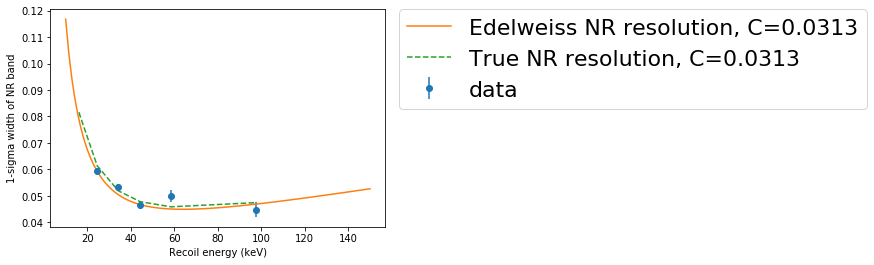

In [54]:
#sig_nr_GGA3 = get_sig_nuc_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, V, aH)
sig_nr_func = get_sig_nuc_func_alt(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, pars, \
                                   aH=0.03808*FWHM_to_SIG, C=0.03132, m=0.00013)

plt.errorbar(res_data["E_recoil"][2::], sig_NR[2::], yerr=sig_NR_err[2::], fmt="o", label="data")

E_recoil_arr = np.linspace(10, 150, 100)
plt.plot(E_recoil_arr, sig_nr_func(E_recoil_arr), label="Edelweiss NR resolution, C=0.0313")

# must sort list to plot line sensibly
s = sorted(zip(E_recoil,model_sig_NR))
E_recoil,model_sig_NR = map(list, zip(*s))
plt.plot(E_recoil, model_sig_NR, '--', label="True NR resolution, C=0.0313")

plt.xlabel("Recoil energy (keV)")
plt.ylabel("1-sigma width of NR band")
#plt.ylim(0, 0.1)

ax1 = plt.gca()
ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

## The following is meant to be a cross-check on the errors reported by Edelweiss

In [6]:
# How many counts are in the gaussian for 
# a particular energy bin?
# Here, GGA1 in bin 40 < ER < 60 keV
N = 125*3+80*2+55*2+25*3
print (N)

720


In [7]:
def std_error_mean(sig, N):
    return sig/np.sqrt(N)

def std_error_stdDev(sig, N):
    return sig/np.sqrt(2*(N-1))

In [17]:
# For the 40 < ER < 50 keV bin for GGA3 NR data,
# the mean is 0.047 and the error is reported as 0.0015
print (std_error_mean(0.047, 500))
print (std_error_stdDev(0.047, 500))

0.0021019038988498023
0.0014877590039073583


In [29]:
np.power([2,2,2],2)
np.multiply([2,2,2], 3)

array([6, 6, 6])